In [ ]:
# Loading drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extracting dataset
import zipfile
zip_path = '/content/drive/My Drive/flickr8k.zip'
extract_path = '/content/extracted_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Dataset exploration

In [ ]:
# Exploring dataset
import os
print("Contents of the dataset directory:")
print(os.listdir(extract_path))

Contents of the dataset directory:
['Images', 'captions.txt']


In [ ]:
# Size of dataset(number of images)
images_dir = os.path.join(extract_path, 'Images')
image_files = os.listdir(images_dir)
print("Number of image files:", len(image_files))
print("Sample image filenames:")
print(image_files[:5])

Number of image files: 8091
Sample image filenames:
['2804374083_311f98f5f2.jpg', '515755283_8f890b3207.jpg', '2832453252_a06f7826a8.jpg', '3620492762_7f6a9b4746.jpg', '3278811919_d5a3432af6.jpg']


In [ ]:
# Size of dataset(number of captions)
captions_file = os.path.join(extract_path, 'captions.txt')
with open(captions_file, 'r') as f:
    captions = f.readlines()

print("Number of captions:", len(captions))
print("\nSample captions:")
for i in range(5):
    print(captions[i])

Number of captions: 40456

Sample captions:
image,caption

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg,A girl going into a wooden building .

1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .



In [ ]:
extract_path = '/content/extracted_data/'

with open(os.path.join(extract_path, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# Generating an image and caption mapping dictionary
from tqdm.notebook import tqdm

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

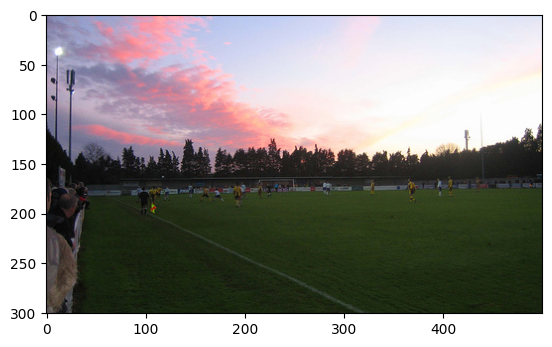

In [ ]:
# Sample Image
from PIL import Image
import matplotlib.pyplot as plt
image_name = '234241682_51d9fabb27.jpg'
image_id = image_name.split('.')[0]
img_path = os.path.join(extract_path, "Images", image_name)
image = Image.open(img_path)
plt.imshow(image)

In [ ]:
# Captions for sample image
captions = mapping[image_id]
for caption in captions:
    print(caption)

A soccer game at sunset
A soccer game being played as the sun sets .
Green sports field with players beneath blue sky with pink clouds
People playing soccer on a soccer field during sunset
Soccer players on a field from a distance .


Text preprocessing / Data preparation

In [ ]:
# Original captions
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [ ]:
def preprocess_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# Preprocessed captions
preprocess_captions(mapping)
mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
image_ids = list(mapping.keys())
len(image_ids)

8091

In [ ]:
# Train/test split
test_len = 10
test = image_ids[len(image_ids)-test_len:]
train = image_ids[:len(image_ids)-test_len]
len(train)

8081

In [ ]:
all_captions = []
for key in train:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

40405

In [ ]:
# Creating and fitting the tokenizer for text sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)
vocab_size

8478

Feature extraction

In [ ]:
# VGG16 model for image feature extraction
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

model = VGG16()
vgg_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
features_vgg = {}
extract_path = '/content/extracted_data/'
directory = os.path.join(extract_path, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = vgg_model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features_vgg[image_id] = feature

553467096/553467096 [==============================] - 26s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# Creating pickle of features to save data in case of a session crash
import pickle
WORKING_DIR = '/content/drive/MyDrive/'
pickle.dump(features_vgg, open(os.path.join(WORKING_DIR, 'v_features.pkl'), 'wb'))

In [ ]:
# Importing the pickle(features dictionary) from drive
import pickle
WORKING_DIR = '/content/drive/MyDrive/'

with open(os.path.join(WORKING_DIR, 'v_features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
# Creating the data gen that is passed to the model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

key = '1001773457_577c3a7d70'
X1, X2, y = list(), list(), list()
captions = mapping[key]
for caption in captions:
  seq = tokenizer.texts_to_sequences([caption])[0]
  for i in range(1, len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
    X1.append(features[key][0])
    X2.append(in_seq)
    y.append(out_seq)

In [ ]:
# Image Features X1
X1[0]

array([0.        , 0.        , 0.49414772, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [ ]:
# Input caption sequence X2
X2[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
# Output caption sequence
y[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
# Creating function for data gen in batch sizes to avoid session crashes
import numpy as np

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y
        X1, X2, y = list(), list(), list()
        n = 0

In [ ]:
# Defining the model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# Image Feature Input Layer
image_input = Input(shape=(4096,))
image_dropout = Dropout(0.4)(image_input)
image_dense = Dense(128, activation='relu')(image_dropout)

# Sequence Input Layer
sequence_input = Input(shape=(max_length,))
sequence_embedding = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
sequence_dropout = Dropout(0.4)(sequence_embedding)
sequence_lstm = LSTM(128)(sequence_dropout)

# Decoder - Combining Image and Sequence Features
decoder_concat = add([image_dense, sequence_lstm])
decoder_dense = Dense(128, activation='relu')(decoder_concat)

# Output Layer
output = Dense(vocab_size, activation='softmax')(decoder_dense)

# Create and Compile the Model
model = Model(inputs=[image_input, sequence_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Display Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2170368   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_1[0][0]']             
                                                                                              

Training the model

In [ ]:
# Training model for 20 epochs
epochs = 5
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

252/252 [==============================] - 66s 261ms/step - loss: 2.5276


In [ ]:
# Saving the model to avoid crashes
model.save('/content/drive/MyDrive/prog20_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Importing the updated model from drive
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/prog20_model.h5')

In [ ]:
# Generates the word from the predicted index from the model with the help of the tokenizer
def idx2word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word
  return None

In [ ]:
# Predicts the sequence of the captions given an image
def predict_caps(model, image, tokenizer, max_length):
  in_text = 'startseq'
  for i in range(max_length):
      sequence = tokenizer.texts_to_sequences([in_text])[0]
      sequence = pad_sequences([sequence], max_length)
      yhat = model.predict([image, sequence], verbose=0)
      yhat = np.argmax(yhat)
      word = idx2word(yhat, tokenizer)
      if word is None:
          break
      in_text += " " + word
      if word == 'endseq':
          break

  return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# Function to print the image given image path
def show_image(image_name):
  image_id = image_name.split('.')[0]
  img_path = os.path.join(extract_path, "Images", image_name)
  image = Image.open(img_path)
  plt.imshow(image)

In [ ]:
# Function to compare predicted and actual captions of a given train image
def generate_caps(image_name):
  image_id = image_name.split('.')[0]
  show_image(image_name)
  y_pred = predict_caps(model, features[image_id], tokenizer, max_length)
  print('Predicted Caption:')
  print(y_pred)

  captions = mapping[image_id]
  print('Actual Captions:')
  for caption in captions:
      print(caption)

Testing the model

Predicted Caption:
startseq two dogs play with each other in the water endseq
Actual Captions:
startseq beige dog with collar looks on as brown dog swims in the water endseq
startseq curly coated dog looking at another dog in the water endseq
startseq curly haired dog is standing on beach while staring at dog in deep water endseq
startseq "a white curly haired dog is wearing harness and watching another black and brown dog in the water ." endseq
startseq wooly dog on beach looks toward another dog in the water endseq


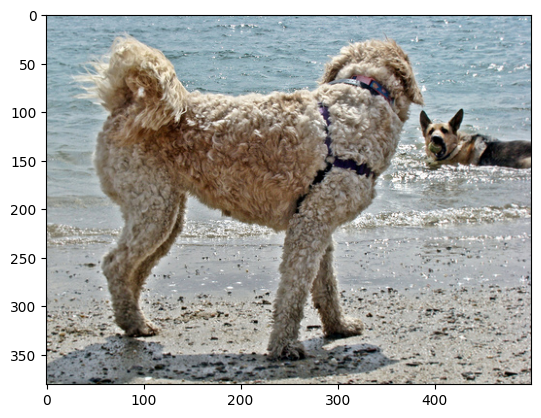

In [ ]:
generate_caps("3431860810_44277cd360.jpg")

Predicted Caption:
startseq little girl is sitting on the stoop of wooden playhouse endseq
Actual Captions:
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


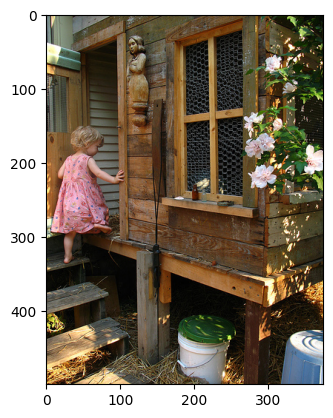

In [ ]:
generate_caps("1000268201_693b08cb0e.jpg")

Predicted Caption:
startseq child is sliding down slide endseq
Actual Captions:
startseq boy goes down an inflatable slide endseq
startseq boy in red slides down an inflatable ride endseq
startseq boy is sliding down in red shirt endseq
startseq child going down an inflatable slide endseq
startseq "a young boy sliding down an inflatable is looking off camera ." endseq


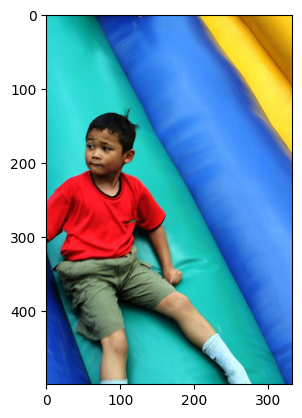

In [ ]:
# Testing on test set
generate_caps(test[1]+".jpg")

Predicted Caption:
startseq two dogs are playing with frisbee in the fields endseq
Actual Captions:
startseq one brown and white dog chasing black and white dog through the grass endseq
startseq the two dogs are running through the grass endseq
startseq two cocker spaniels running through the grass endseq
startseq two dogs are running through green yard endseq
startseq two dogs are running through the grass near house and trees endseq


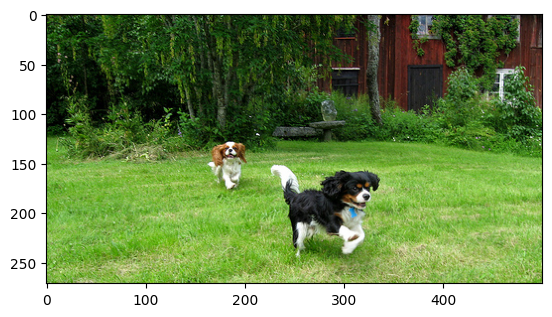

In [ ]:
generate_caps(test[2]+".jpg")

In [ ]:
# Accuracy of model in the test set
from nltk.translate.bleu_score import sentence_bleu
scores = []
for i in test:
  actual = mapping[i]
  predicted = predict_caps(model, features[i], tokenizer, max_length)
  scores.append(sentence_bleu(actual, predicted))

mean = sum(scores)/len(scores)
mean

0.6768895947452911

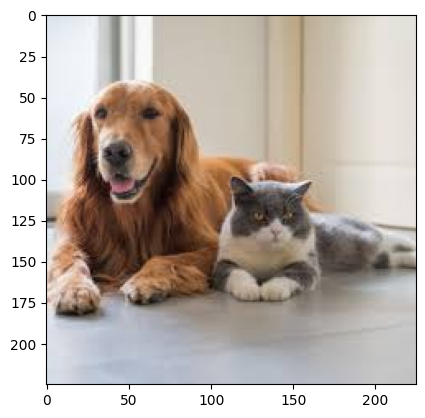

In [ ]:
# Importing random image from online and testing the model
image = Image.open('/content/test.jpeg')

plt.imshow(image)

In [ ]:
image = image.resize((224, 224))

In [ ]:
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = vgg_model.predict(image, verbose=0)

In [ ]:
predict_caps(model, feature, tokenizer, max_length)

'startseq brown dog is jumping over the top of the water endseq'